# Brain Tumor Classification using CNN 

# MODULES

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
# Changing Working Directory
os.chdir(r"...\Brain Tumor Detection using CNN")

# PARAMETERS

In [3]:
epoch=100
batch_size_val=30
imageDimensions=(128,128,3) #bgr

testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [4]:
# Catergorial Representaion by One Hot Encoding
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

OneHotEncoder()

# Importing Images

In [5]:
# Updates result list for images with tumor
data = [] # numpy array
paths = [] # all images
result = [] # images label

for r, d, f in os.walk(r'brain_tumor_dataset\yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    
    img = Image.open(path)
    img = img.resize((imageDimensions[0],imageDimensions[1]))
    img = np.array(img)
    if(img.shape == (imageDimensions[0],imageDimensions[1],imageDimensions[2])):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [6]:
# Updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"brain_tumor_dataset\no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((imageDimensions[0],imageDimensions[1]))
    img = np.array(img)
    if(img.shape == (imageDimensions[0],imageDimensions[1],imageDimensions[2])):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

# Storing as NUMPY array

In [7]:
data = np.array(data) # Stores images

In [19]:
result = np.array(result) # Stores respective images's label
print(result.shape)

(138, 2)


# Data Splitting

In [15]:
# 80% Training 20% Testing of total data
X_train,X_test,y_train,y_test = train_test_split(data, result, test_size=testRatio, shuffle=True, random_state=0)

# 80% Training 20% Validation of training data
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio,shuffle=True, random_state=0)

# 64%-training
# 16%-validation
# 20%-testing

In [36]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)
assert (X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:]==(imageDimensions))," The dimesions of the Training images are wrong "
assert (X_validation.shape[1:]==(imageDimensions))," The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:]==(imageDimensions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(110, 128, 128, 3) (110, 2)
Validation(28, 128, 128, 3) (28, 2)
Test(28, 128, 128, 3) (28, 2)


# Data Augmentation 

In [37]:
# AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# CNN Model

In [38]:

def myModel():
    no_Of_Filters = 64
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 128 128 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimensions[0],imageDimensions[1],imageDimensions[2]),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
    model.add(Dense(units=64,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.2))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(2, activation='softmax'))  # OUTPUT LAYER
    
    # COMPILE MODEL
    model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Model Training

In [43]:
model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),epochs=epoch,validation_data=(X_validation, y_validation), shuffle=1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
dense_15 (Dense)             (None, 60, 60, 64)        4160      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 58, 58, 32)        18464     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 32)       

Epoch 46/100
4/4 [==============================] - 5s 1s/step - loss: 0.5701 - accuracy: 0.7636 - val_loss: 0.6835 - val_accuracy: 0.6429
Epoch 47/100
4/4 [==============================] - 5s 1s/step - loss: 0.5171 - accuracy: 0.8091 - val_loss: 0.6705 - val_accuracy: 0.6786
Epoch 48/100
4/4 [==============================] - 5s 1s/step - loss: 0.5957 - accuracy: 0.7545 - val_loss: 0.6682 - val_accuracy: 0.7500
Epoch 49/100
4/4 [==============================] - 5s 1s/step - loss: 0.5566 - accuracy: 0.7727 - val_loss: 0.6420 - val_accuracy: 0.6786
Epoch 50/100
4/4 [==============================] - 5s 1s/step - loss: 0.5597 - accuracy: 0.7455 - val_loss: 0.6388 - val_accuracy: 0.6786
Epoch 51/100
4/4 [==============================] - 5s 1s/step - loss: 0.5508 - accuracy: 0.7273 - val_loss: 0.6458 - val_accuracy: 0.7500
Epoch 52/100
4/4 [==============================] - 5s 1s/step - loss: 0.5626 - accuracy: 0.7636 - val_loss: 0.6528 - val_accuracy: 0.7500
Epoch 53/100
4/4 [=========

# PLOTS

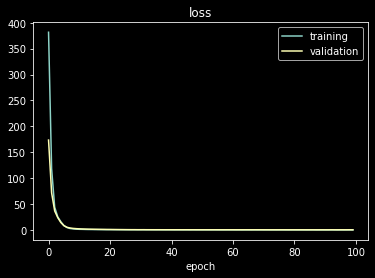

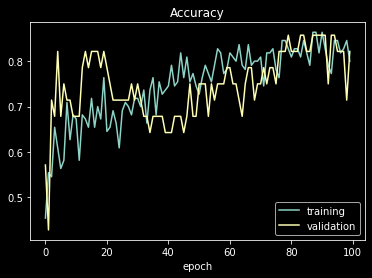

Test Score: 0.6011164784431458
Test Accuracy: 0.8214285969734192


In [45]:
plt.style.use('dark_background') # plot style

# Loss Graph
plt.figure(0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

# Accuracy Graph
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

# Model Score
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])


# Saving Model

In [18]:
os.chdir(r"D:\amrita\sem 3\IBS3\ENDSEM\Brain Tumor Detection using CNN")
model.save('modelnicename.h5')

# TESTING

In [1]:
from matplotlib.pyplot import imshow
from tkinter import filedialog
from tensorflow import keras
from PIL import ImageTk
from tkinter import *
import tkinter as tk
import numpy as np
import PIL.Image
import os

In [2]:
# Changing current directory location
os.chdir(r"D:\amrita\sem 3\IBS3\ENDSEM\Brain Tumor Detection using CNN")

In [3]:
# Importing saved model
model = keras.models.load_model('modelnicename.h5')

In [4]:
# Classification Function
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

# Sample Classification

[[0.10888572 0.8911143 ]]
89.11142945289612% Confidence. No, Its not a tumor


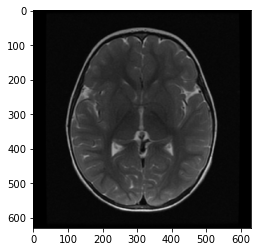

In [5]:
img = PIL.Image.open(r"brain_tumor_dataset/no/2 no.jpeg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
print(res)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence. ' + names(classification))

# Graphical User Interface (GUI)

In [ ]:
import warnings

# Window Initialization
top=tk.Tk()
top.geometry('700x500')
top.title('Brain Tumor Detection using CNN')
top.configure(background='deep sky blue')

# Tumor or Not Text Box
label=Label(top,background='deep sky blue', font=('Raleway',15,'bold'))
sign_image = Label(top)
sign_image.configure(background='deep sky blue')

# Classification
def classify(file_path):
    global label_packed
    im=PIL.Image.open(file_path)
    x = np.array(im.resize((128,128)))
    x = x.reshape(1,128,128,3)
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]
    print(str(res[0][classification]*100) + '% Confidence, ' + names(classification))
    label.configure(foreground='indianred1',background='white', font=('Raleway',20),text=names(classification)) 
    warnings.filterwarnings('ignore')
    
# Classify Button
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5) #Calling classify function
    classify_b.configure(background='white', foreground='#20bebe',font=('Raleway',12,'bold'))
    classify_b.place(relx=0.55,rely=0.845)

# Function for Uploading Image
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=PIL.Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/3),(top.winfo_height()/3)))
        im=ImageTk.PhotoImage(uploaded)
        img = tk.Label(top, image=im)
        img.image = im
        img.place(x=260, y=200)
        show_classify_button(file_path) # Showing classification button after we upload the image
    except:
        pass
    
# Upload Button
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='white', foreground='#20bebe',font=('Raleway',12,'bold'))
upload.place(relx=0.275,rely=0.845)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
# Heading
heading = Label(top, text="Brain Tumor Detection",pady=18, font=('Raleway',20,'bold'))
heading.configure(background='white',foreground='#20bebe')
heading.pack()
top.mainloop()

# Warnings Handling
warnings.filterwarnings('ignore')

97.96732664108276% Confidence, No, Its not a tumor
94.68491077423096% Confidence, No, Its not a tumor
97.96732664108276% Confidence, No, Its not a tumor
